In [6]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

In [7]:
tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/fashion_data', 
                                  source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/',
                                  one_hot=True)

Extracting input/fashion_data/train-images-idx3-ubyte.gz
Extracting input/fashion_data/train-labels-idx1-ubyte.gz
Extracting input/fashion_data/t10k-images-idx3-ubyte.gz
Extracting input/fashion_data/t10k-labels-idx1-ubyte.gz


y = 3 (Dress)


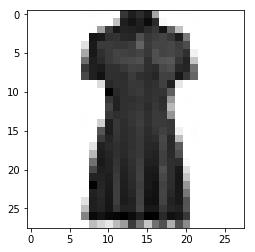

In [8]:
# From: https://medium.com/tensorist/classifying-fashion-articles-using-tensorflow-fashion-mnist-f22e8a04728a
# Our Fashion MNIST labels
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# Take one sample

# Get 28x28 image
sample_1 = mnist.train.images[47].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_1 = np.where(mnist.train.labels[47] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()

In [9]:
def cnn_with_hyperparameters(dropout, starter_learning_rate):
    # 1. Define Variables and Placeholders
    X = tf.placeholder(tf.float32, [None, 784]) # The first dimension (None) will index the images
    Y_ = tf.placeholder(tf.float32, [None, 10])       # Correct answers

    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    XX = tf.reshape(X, [-1, 28, 28, 1])

    # placeholder for probability of keeping a node during dropout = 1.0 
    # at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)

    # Weight and bias variables
    # Weights initialized with small random values between -0.2 and +0.2
    # The weight variables from your convolutional layers should follow 4-dimensional tensors of (patch_height, patch_width, input_channels, output_channels)
    # Convolutional layers
    CL1W = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
    CL1B = tf.Variable(tf.zeros([4]))
    CL2W = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev=0.1))
    CL2B = tf.Variable(tf.zeros([8]))
    CL3W = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
    CL3B = tf.Variable(tf.zeros([12]))
    # Fully connected layer
    FCW = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))
    FCB = tf.Variable(tf.zeros([200]))
    # Read out layer
    ROW = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
    ROB = tf.Variable(tf.zeros([10]))

    # Convolutional and ReLU layers
    CL1 = tf.nn.conv2d(XX, CL1W, strides=[1, 1, 1, 1], padding='SAME')
    Y1 = tf.nn.relu(CL1 + CL1B)
    Y1d = tf.nn.dropout(Y1, pkeep)
    CL2 = tf.nn.conv2d(Y1d, CL2W, strides=[1, 2, 2, 1], padding='SAME')
    Y2 = tf.nn.relu(CL2 + CL2B)
    Y2d = tf.nn.dropout(Y2, pkeep)
    CL3 = tf.nn.conv2d(Y2d, CL3W, strides=[1, 2, 2, 1], padding='SAME')
    Y3 = tf.nn.relu(CL3 + CL3B)
    Y3d = tf.nn.dropout(Y3, pkeep)

    # Fully connected layer
    # Reshape to vector
    # Y3.shape = (?, 7, 7, 12)
    #Y3RS = tf.reshape(Y3, [-1, 28 * 28 * 1])
    Y3RS = tf.reshape(Y3d, [-1, 7 * 7 * 12])
    Y4 = tf.nn.relu(tf.matmul(Y3RS, FCW) + FCB)

    # Read out layer
    Ylogits = tf.matmul(Y4, ROW) + ROB
    Y = tf.nn.softmax(Ylogits)
    
    # 3. Define the loss function  
    # WARNING: This op expects unscaled logits, since it performs a softmax on logits internally for efficiency. Do not call this op with the output of softmax, as it will produce incorrect results.
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_) # calculate cross-entropy with logits
    cross_entropy = tf.reduce_mean(cross_entropy)
    
    # 4. Define the accuracy
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 5. Define an optimizer - Gradient Descent Optimizer or Adam Optimizer

    # https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay
    global_step = tf.Variable(0, trainable=False)
    # decay every 100 steps with a base of 0.96
    decay_steps = 100
    decay_rate = 0.96
    # If the argument staircase is True, then global_step / decay_steps is an integer division and the decayed learning rate follows a staircase function.
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate, staircase=True)

    # Note: Passing global_step to minimize() will increment it at each step.
    #train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
    
    # initialize
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    
    # 3. In the training step - provide the appropriate pkeep
    # 4. In the training step, if you used a placeholder - adjust learning rate - according to exponential decay rate
    def training_step(i, update_test_data, update_train_data, dropout):

        print "\r", i,
        ####### actual learning 
        # reading batches of 100 images with 100 labels
        batch_X, batch_Y = mnist.train.next_batch(100)
        #print(batch_X.shape)
        # the backpropagation training step
        sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep: dropout})

        ####### evaluating model performance for printing purposes
        # evaluation used to later visualize how well you did at a particular time in the training
        train_a = []
        train_c = []
        test_a = []
        test_c = []
        if update_train_data:
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep: 1})
            train_a.append(a)
            train_c.append(c)

        if update_test_data:
            a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels,  pkeep: 1})
            test_a.append(a)
            test_c.append(c)


        return (train_a, train_c, test_a, test_c)
    
    # 6. Train and test the model, store the accuracy and loss per iteration
    train_a = []
    train_c = []
    test_a = []
    test_c = []

    training_iter = 10000
    epoch_size = 100
    for i in range(training_iter):
        test = False
        if i % epoch_size == 0:
            test = True
        a, c, ta, tc = training_step(i, test, test, dropout)
        train_a += a
        train_c += c
        test_a += ta
        test_c += tc
        
    # 7. Plot and visualise the accuracy and loss
    # accuracy training vs testing dataset
    plt.plot(train_a)
    plt.plot(test_a)
    plt.grid(True)
    plt.show()

    # loss training vs testing dataset
    plt.plot(train_c)
    plt.plot(test_c)
    plt.grid(True)
    plt.show()

    # Zoom in on the tail of the plots
    zoom_point = 50
    x_range = range(zoom_point,training_iter/epoch_size)
    plt.plot(x_range, train_a[zoom_point:])
    plt.plot(x_range, test_a[zoom_point:])
    plt.grid(True)
    plt.show()

    plt.plot(train_c[zoom_point:])
    plt.plot(test_c[zoom_point:])
    plt.grid(True)
    plt.show()
    
    # Accuracy
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1}))

9999                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

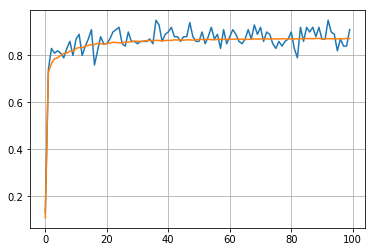

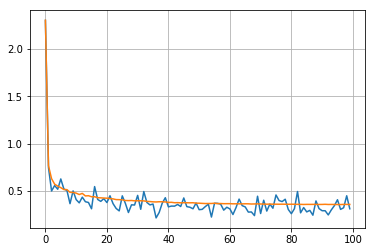

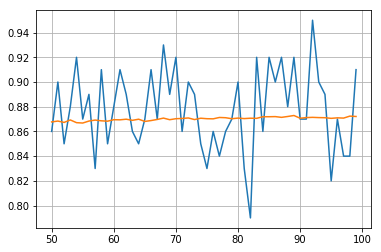

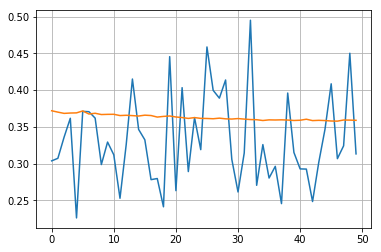

 0.8723


In [10]:
# Task 5 : Improving Predictions with Hyperparameter Optimization
# Hyperparameters
# args_dict = {’learning_rate’: [0.001, 0.0001, 0.00001], ’dropout’: [0.5, 0.7]}
# Call cnn_with_hyperparameters manually with different combination of the parameters

# 1
cnn_with_hyperparameters(0.5, 0.001)
#cnn_with_hyperparameters(0.5, 0.0001)
#cnn_with_hyperparameters(0.5, 0.00001)
#cnn_with_hyperparameters(0.7, 0.001)
#cnn_with_hyperparameters(0.7, 0.0001)
#cnn_with_hyperparameters(0.7, 0.00001)